# Лабораторная работа 3. Методы обучения нейронных сетей

### Содержание
1. [Работа с данными](#Работа-с-данными)
1. [Построение модели](#Построение-модели)
1. [Исследование гиперпараметров](#Исследование-гиперпараметров)

В данной лабораторной работе потребуется исследовать эффективность различных приемов и методов обучения нейронных сетей:
* количество нейронов скрытого слоя;
* количество эпох обучения;
* функции активации;
* регуляризация;
* инициализация весов;
* нормализация по мини-батчам;
* методы градиентного спуска;
* адаптивные методы градиентного спуска.

### Работа с данными

Исследовать эти приемы и методы предлагается на [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) – наборе черно-белых рукописных цифр размером 28x28 пикселей:

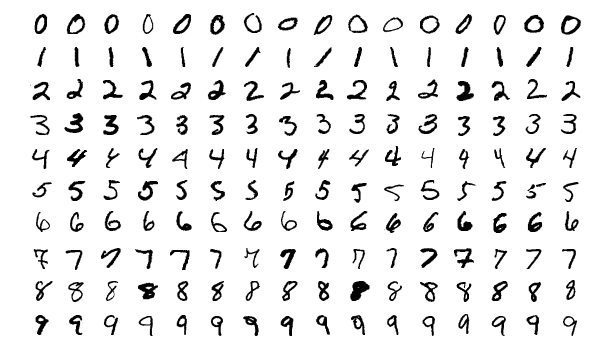

MNIST содержит 60 000 изображений для обучения и 10 000 изображений для тестирования.

In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [29]:
torch.manual_seed(42)

---
Задаем гиперпараметры (некоторые из них нужно будет менять в процессе исследования):

In [30]:
input_size = 28 * 28 # 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

---
Код работы с данными (загрузка, предобработка, сэмплирование) должен быть отделен от кода работы с моделями (создание, обучение, тестирование).  
PyTorch предоставляет два класса для работы с данными: `Dataset` и `DataLoader`:  
- класс [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) позволяет загружать и хранить как предустановленные наборы данных (например, MNIST), так и свои собственные;
- класс [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) позволяет осуществлять доступ к данным в процессе обучения.  

В PyTorch есть множество предустановленных наборов данных:
- [текстов](https://pytorch.org/text/stable/datasets.html);
- [изображений](https://pytorch.org/vision/stable/datasets.html);
- [аудио](https://pytorch.org/audio/stable/datasets.html).

Ниже приведен код загрузки MNIST:

In [31]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [32]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

---
Список всех классов в `Dataset`:

In [33]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

К примерам в `Dataset` можно обращаться по индексу. Выведем, например, метку самого первого примера:

In [34]:
print(f'Label of the first example is {train_dataset[0][1]}.')

Label of the first example is 5.


---
Цифры можно нарисовать:

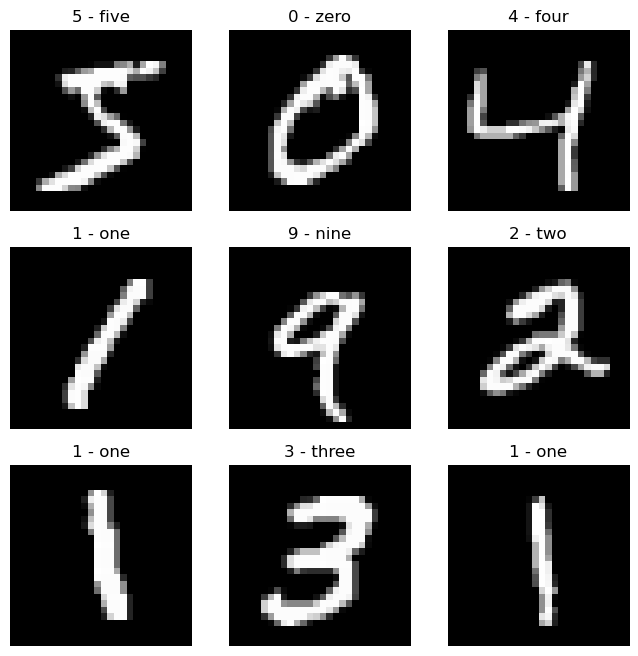

In [35]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = train_dataset[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

При загрузке мы применили [преобразование данных](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html): `transform=transforms.ToTensor()` осуществляет преобразование чисел в тензоры и нормирует к диапазону [0, 1].  
Также можно применять преобразования к меткам (например, переводить индекс в *OneHot Encoding*), для этого служит параметр `target_transform`.

---
#### Терминология  
- *Батч (batch)* – подмножество обучающих данных, которое подается на сеть в процессе обучения. после чего веса сети обновляются.  
    - `batch_size = len(train_dataset)` – Vanilla Gradient Descent или Batch Gradient Descent
    - `batch_size = 1` – Stochastic Gradient Descent
    - `1 < batch_size < len(train_dataset)` – Mini-Batch Gradient Descent
- *Шаг (step)* – период обработки одного батча.  
- *Эпоха (epoch)* – период обработки всего обучающего множества; количество шагов в эпохе равно количеству батчей в обучающем множестве. 

---
Для подготовки данных для обучения служит класс `DataLoader`. Он позволяет случайным образом формировать мини-батчи и перемешивать данные перед каждой эпохой обучения.  
Зададим объекты `DataLoader` на основе MNIST:

In [36]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [37]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

---
По объектам `DataLoader` можно осуществлять итерацию; при этом на каждом шаге будет возвращаться подмножество размером `batch_size`:

In [38]:
print(f'Number of batches = {len(train_loader)}')

train_data, train_labels = next(iter(train_loader))
print(f'Size of the batch = {len(train_data)}')

print(f'Number of all the samples = {len(train_loader) * len(train_data)}')

Number of batches = 600
Size of the batch = 100
Number of all the samples = 60000


После того, как все батчи будут выданы (по окончании эпохи обучения), в случае, если `shuffle=True`, произойдет перемешивание данных и на следующей эпохе батчи будут уже другими.

### Построение модели

#### Задание.  
Опишите класс `NeuralNetwork` для распознавания MNIST: двухслойная нейронная сеть прямого распространения, количество нейронов скрытого слоя – `hidden_size`, функция активации скрытого слоя – `ReLU`. Выходной слой пусть остается линейным, без функции активации.

In [39]:
class NeuralNetwork(nn.Module):
    # Ваш код
    def __init__(self, input_size=28*28, hidden_size=500, output_size=10):
        # Инициализация двухслойной нейронной сети.
        # Параметры:
        #    input_size (int): Размер входного вектора (28x28=784 для MNIST)
        #    hidden_size (int): Количество нейронов в скрытом слое
        #    output_size (int): Количество нейронов выходного слоя (10 классов для MNIST)
        
        super(NeuralNetwork, self).__init__()
        
        # Скрытый слой: линейное преобразование + ReLU
        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        
        # Выходной слой: линейное преобразование (без активации)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Прямой проход через сеть.
        # Параметры: x (torch.Tensor): Входные данные (размер батча x 784)
        # Возвращает: torch.Tensor: Выход сети (размер батча x 10)
        
        # Преобразуем вход в одномерный вектор (если это еще не сделано)
        x = x.view(x.size(0), -1)
        
        # Пропускаем через скрытый слой
        x = self.hidden_layer(x)
        
        # Пропускаем через выходной слой
        x = self.output_layer(x)
        
        return x

#### Задание.  
Создайте объект класса `NeuralNetwork`, перенесите его на GPU.  
Задайте функцию потерь (например, `CrossEntropyLoss`) и любой оптимизатор.

In [40]:
# Ваш код
import torch.optim as optim

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем нейронную сеть
model = NeuralNetwork(hidden_size=hidden_size).to(device)  # Переносим модель на GPU

# Определяем функцию потерь (кросс-энтропия)
loss_fn = nn.CrossEntropyLoss()

# Выбираем оптимизатор (Adam с learning_rate=0.001)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Выводим информацию о модели
print(model)

Используемое устройство: cpu
NeuralNetwork(
  (hidden_layer): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=500, out_features=10, bias=True)
)


---
Напишем цикл обучения для нашей сети:

In [41]:
start_time = time()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
            
print(f'Time = {time() - start_time:.1f}')

Epoch [1/5], Step [100/600], Loss: 0.4284
Epoch [1/5], Step [200/600], Loss: 0.2743
Epoch [1/5], Step [300/600], Loss: 0.1301
Epoch [1/5], Step [400/600], Loss: 0.2036
Epoch [1/5], Step [500/600], Loss: 0.1535
Epoch [1/5], Step [600/600], Loss: 0.2612
Epoch [2/5], Step [100/600], Loss: 0.1585
Epoch [2/5], Step [200/600], Loss: 0.2185
Epoch [2/5], Step [300/600], Loss: 0.1700
Epoch [2/5], Step [400/600], Loss: 0.0613
Epoch [2/5], Step [500/600], Loss: 0.0541
Epoch [2/5], Step [600/600], Loss: 0.0715
Epoch [3/5], Step [100/600], Loss: 0.1230
Epoch [3/5], Step [200/600], Loss: 0.1168
Epoch [3/5], Step [300/600], Loss: 0.1234
Epoch [3/5], Step [400/600], Loss: 0.0921
Epoch [3/5], Step [500/600], Loss: 0.0865
Epoch [3/5], Step [600/600], Loss: 0.0728
Epoch [4/5], Step [100/600], Loss: 0.0555
Epoch [4/5], Step [200/600], Loss: 0.0304
Epoch [4/5], Step [300/600], Loss: 0.0491
Epoch [4/5], Step [400/600], Loss: 0.0874
Epoch [4/5], Step [500/600], Loss: 0.0893
Epoch [4/5], Step [600/600], Loss:

#### Задание.  
Постройте график зависимости потерь на мини-батче от шага обучения.

Epoch [1/5], Step [100/600], Loss: 0.0111
Epoch [1/5], Step [200/600], Loss: 0.0112
Epoch [1/5], Step [300/600], Loss: 0.0509
Epoch [1/5], Step [400/600], Loss: 0.0752
Epoch [1/5], Step [500/600], Loss: 0.0252
Epoch [1/5], Step [600/600], Loss: 0.0169
Epoch [2/5], Step [100/600], Loss: 0.0644
Epoch [2/5], Step [200/600], Loss: 0.0057
Epoch [2/5], Step [300/600], Loss: 0.0795
Epoch [2/5], Step [400/600], Loss: 0.0070
Epoch [2/5], Step [500/600], Loss: 0.0218
Epoch [2/5], Step [600/600], Loss: 0.0366
Epoch [3/5], Step [100/600], Loss: 0.0332
Epoch [3/5], Step [200/600], Loss: 0.0051
Epoch [3/5], Step [300/600], Loss: 0.0040
Epoch [3/5], Step [400/600], Loss: 0.0200
Epoch [3/5], Step [500/600], Loss: 0.0380
Epoch [3/5], Step [600/600], Loss: 0.0066
Epoch [4/5], Step [100/600], Loss: 0.0032
Epoch [4/5], Step [200/600], Loss: 0.0121
Epoch [4/5], Step [300/600], Loss: 0.0057
Epoch [4/5], Step [400/600], Loss: 0.0114
Epoch [4/5], Step [500/600], Loss: 0.0060
Epoch [4/5], Step [600/600], Loss:

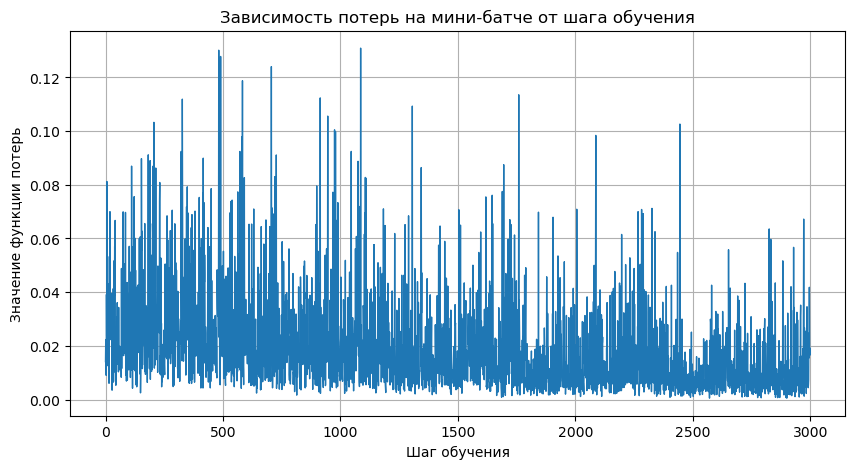

In [42]:
# Ваш код
import time 
import matplotlib.pyplot as plt

start_time = time.time()  

# Для хранения значений потерь и шагов
loss_history = []
step_history = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Переносим тензоры на устройство (GPU/CPU)
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Прямой проход
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Сохраняем значения для графика
        loss_history.append(loss.item())
        step_history.append(epoch * total_step + i)
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
            
print(f'Training time = {time.time() - start_time:.1f} seconds')  

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(step_history, loss_history, linewidth=1)
plt.title('Зависимость потерь на мини-батче от шага обучения')
plt.xlabel('Шаг обучения')
plt.ylabel('Значение функции потерь')
plt.grid(True)
plt.show()

---
Получим предсказания модели на тестовых данных:

In [43]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)

print(f'last predict = {predicted[-1]}, true label = {labels[-1]}')

last predict = 6, true label = 6


#### Задание.  
Вычислите правильность (Accuracy) модели на тестовых данных.

In [44]:
# Ваш код

# Переводим модель в режим оценки
model.eval()

correct = 0
total = 0

with torch.no_grad():  # Отключаем вычисление градиентов
    for images, labels in test_loader:
        # Переносим данные на устройство (GPU/CPU)
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Прямой проход
        outputs = model(images)
        
        # Получаем предсказанные классы
        _, predicted = torch.max(outputs.data, 1)
        
        # Считаем правильные предсказания
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Вычисляем точность
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 97.94%


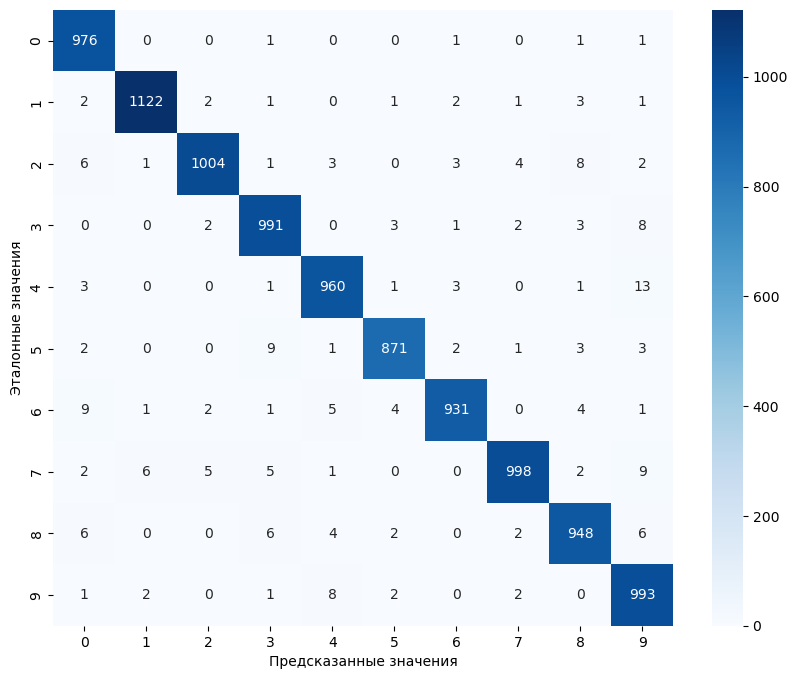

In [45]:
# Для анализа ошибок построим матрицу ошибок по классам
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Собираем все предсказания и истинные метки
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Строим матрицу ошибок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные значения')
plt.ylabel('Эталонные значения')
plt.show()

---
Сохраним полученную модель:

In [46]:
torch.save(model.state_dict(), 'model.ckpt')

### Исследование гиперпараметров

#### Задание. 

Подберите гиперпараметры нейронной сети, обеспечивающие наилучшее качество классификации тестовых данных MNIST.  
Требуется исследовать следующие гиперпараметры:
* количество нейронов скрытого слоя – не менее 5 вариантов;
* количество эпох обучения – не менее 3 вариантов;
* функции активации – не менее 3 вариантов (симметричные и несимметричные);
* регуляризация – weight decay (L2) и dropout;
* инициализация весов (Xavier и Kaiming);
* нормализация по мини-батчам (наличие/отсутствие);
* методы градиентного спуска (SGD, momentum SGD, Nesterov SGD);
* адаптивные методы градиентного спуска (AdaGrad, AdaDelta, RMSProp, Adam, AdamW).

Необязательно выполнять полный перебор – можно осуществить жадный поиск.  

Результаты подбора вывести в удобном виде.  

Для всех вариантов градиентного спуска нарисовать графики процесса обучения.  


**Замечание**. Напомним, что в этом случае тестовый набор MNIST играет роль валидационного набора, так как подбор оптимальных значений гиперапараметров на тестовых данных может приводить к переобучению!

In [100]:
# Ваш код
from collections import defaultdict
from torch.utils.data import DataLoader

# Конфигурация эксперимента
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    batch_size = 128 # Размер мини-батча для обучения (128 образцов за одну итерацию)
    test_batch_size = 1000 # Размер батча для тестирования
    seed = 42 # Воспроизводимость
    log_interval = 100 # Частота логирования (вывод информации в консоль каждые 100 батчей)

# Устанавливает seed для CPU. Фиксирует начальное состояние генератора случайных чисел PyTorch
torch.manual_seed(Config.seed)

# Фиксирует seed для всех GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(Config.seed)

# Параметры для исследования
params_grid = {
    'hidden_size': [64, 128, 256, 512, 1024],         # Количество нейронов скрытого слоя
    'epochs': [5, 10, 15],                            # Количество эпох обучения
    'activation': ['relu', 'leaky_relu', 'tanh'],     # Функции активации (Tanh симметрична относительно начала координат, ReLU и LeakyReLU возвращают только положительные/асимметричные значения)
    'weight_decay': [0, 1e-4, 1e-3],                  # Снижение весов
    'dropout': [0, 0.2, 0.5],                         # Процент выбрасывания случайных нейронов
    'init_method': ['xavier', 'kaiming'],             # Инициализация весов
    'use_bn': [True, False],                          # Нормализация по мини-батчам (есть, нет)
    'optimizer': [
        ('SGD', {'lr': 0.1}),
        ('Momentum', {'lr': 0.01, 'momentum': 0.9}),
        ('Nesterov', {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}),
        ('Adam', {'lr': 0.001}),
        ('RMSprop', {'lr': 0.01}),
        ('Adagrad', {'lr': 0.1})
    ]                                                 # Оптимизаторы
}

# Модель с настраиваемыми (Customizable) параметрами
class CustomizableNN(nn.Module):
    def __init__(self, hidden_size=128, activation='relu', use_bn=False, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        
        # Выбор функции активации
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("Unknown activation")

        # Нормализация по мини-батчам
        self.use_bn = use_bn
        if use_bn:
            self.bn = nn.BatchNorm1d(hidden_size)
            
        self.dropout = nn.Dropout(dropout)

    # Прямой проход
    def forward(self, x): 
        #x = x.view(-1, 784) 
        # Преобразуем вход в одномерный вектор (если это еще не сделано)
        x = x.view(x.size(0), -1)
        x = self.fc1(x) # Скрытый слой
        
        if self.use_bn: 
            x = self.bn(x) # Нормализация по миним-батчам
            
        x = self.activation(x) # Активация
        x = self.dropout(x) 
        x = self.fc2(x) # Выходной слой
        return x

# Инициализация весов
def init_weights(m, method='xavier'):
    # Инициализация весов
    if isinstance(m, nn.Linear):
        if method == 'xavier':
            nn.init.xavier_normal_(m.weight)
        elif method == 'kaiming':
            nn.init.kaiming_normal_(m.weight)
        elif method == 'default':
            pass
        # Инициализация смещений
        if m.bias is not None:
            m.bias.data.fill_(0.01)

# Функция обучения
def train(model, optimizer, train_loader, epochs=10):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    train_loss = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(Config.device), target.to(Config.device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            if batch_idx % Config.log_interval == 0:
                train_loss.append(loss.item())
        
        epoch_loss /= len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')
    
    return train_loss

# Функция тестирования
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(Config.device), target.to(Config.device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [101]:
# Жадный поиск (по одному параметру за раз)
results = defaultdict(list)
best_accuracy = 0
best_params = {}

Исследование размера скрытого слоя
hidden_size = 64
Epoch 1, Loss: 0.4759
Epoch 2, Loss: 0.2213
Epoch 3, Loss: 0.1716
Epoch 4, Loss: 0.1400
Epoch 5, Loss: 0.1185
Accuracy on test = 96.45

hidden_size = 128
Epoch 1, Loss: 0.4192
Epoch 2, Loss: 0.2045
Epoch 3, Loss: 0.1478
Epoch 4, Loss: 0.1168
Epoch 5, Loss: 0.0937
Accuracy on test = 97.06

hidden_size = 256
Epoch 1, Loss: 0.3621
Epoch 2, Loss: 0.1598
Epoch 3, Loss: 0.1098
Epoch 4, Loss: 0.0818
Epoch 5, Loss: 0.0636
Accuracy on test = 97.3

hidden_size = 512
Epoch 1, Loss: 0.3146
Epoch 2, Loss: 0.1283
Epoch 3, Loss: 0.0847
Epoch 4, Loss: 0.0613
Epoch 5, Loss: 0.0453
Accuracy on test = 97.79

hidden_size = 1024
Epoch 1, Loss: 0.2712
Epoch 2, Loss: 0.1012
Epoch 3, Loss: 0.0639
Epoch 4, Loss: 0.0438
Epoch 5, Loss: 0.0317
Accuracy on test = 97.82



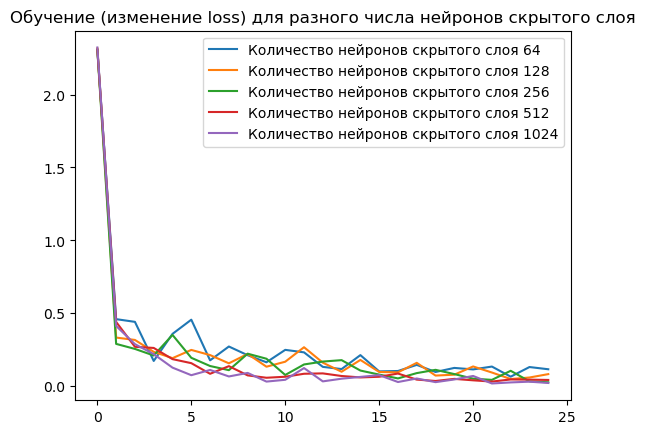


Best accuracy: 97.82%
Best parameters:
hidden_size: 1024
epochs: 5
activation: relu
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [102]:
# Базовые параметры
base_params = {
    'hidden_size': 500,
    'epochs': 5,
    'activation': 'relu',
    'weight_decay': 0,
    'dropout': 0,
    'init_method': 'xavier',
    'use_bn': False,
    'optimizer': ('Adam', {'lr': 0.001})
}

# Исследуем размер скрытого слоя

print("Исследование размера скрытого слоя")
for size in params_grid['hidden_size']:
    print(f'hidden_size = {size}')
    params = base_params.copy()
    params['hidden_size'] = size
    
    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = optim.Adam(model.parameters(), lr=params['optimizer'][1]['lr'], 
                          weight_decay=params['weight_decay'])
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}\n')
    
    results['hidden_size'].append((size, accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
    
    plt.plot(train_loss, label=f'Количество нейронов скрытого слоя {size}')
plt.legend()
plt.title('Обучение (изменение loss) для разного числа нейронов скрытого слоя')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")


In [103]:
# Аналогично, как для hidden_size, исследуем другие параметры, задавая лучшие значения уже исследованных параметров, т.е. используя best_params:


Исследование количества эпох
epochs = 5
Epoch 1, Loss: 0.2751
Epoch 2, Loss: 0.1016
Epoch 3, Loss: 0.0645
Epoch 4, Loss: 0.0449
Epoch 5, Loss: 0.0328
Accuracy on test = 98.01
epochs = 10
Epoch 1, Loss: 0.2727
Epoch 2, Loss: 0.1024
Epoch 3, Loss: 0.0655
Epoch 4, Loss: 0.0455
Epoch 5, Loss: 0.0327
Epoch 6, Loss: 0.0241
Epoch 7, Loss: 0.0165
Epoch 8, Loss: 0.0125
Epoch 9, Loss: 0.0109
Epoch 10, Loss: 0.0089
Accuracy on test = 98.35
epochs = 15
Epoch 1, Loss: 0.2743
Epoch 2, Loss: 0.1037
Epoch 3, Loss: 0.0654
Epoch 4, Loss: 0.0453
Epoch 5, Loss: 0.0328
Epoch 6, Loss: 0.0236
Epoch 7, Loss: 0.0178
Epoch 8, Loss: 0.0145
Epoch 9, Loss: 0.0104
Epoch 10, Loss: 0.0080
Epoch 11, Loss: 0.0066
Epoch 12, Loss: 0.0057
Epoch 13, Loss: 0.0092
Epoch 14, Loss: 0.0048
Epoch 15, Loss: 0.0082
Accuracy on test = 98.3


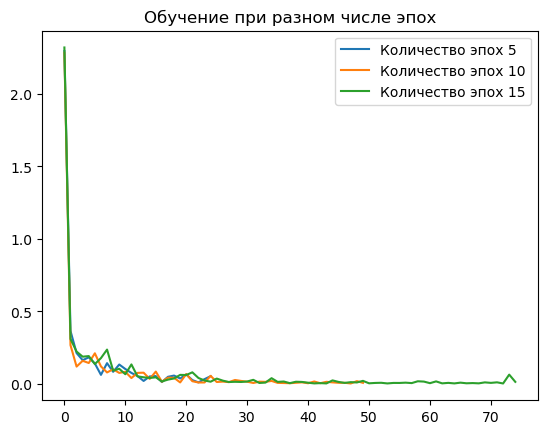


Best accuracy: 98.35%
Best parameters:
hidden_size: 1024
epochs: 10
activation: relu
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [104]:
# Исследуем количество эпох

print("Исследование количества эпох")
for epoch in params_grid['epochs']:
    print(f'epochs = {epoch}')
    params = best_params.copy()
    params['epochs'] = epoch
    
    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = optim.Adam(model.parameters(), lr=params['optimizer'][1]['lr'], 
                          weight_decay=params['weight_decay'])
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}')
    
    results['epochs'].append((epoch, accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
    
    plt.plot(train_loss, label=f'Количество эпох {epoch}')
plt.legend()
plt.title('Обучение при разном числе эпох')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Исследование функции активации
activation = relu
Epoch 1, Loss: 0.2699
Epoch 2, Loss: 0.1019
Epoch 3, Loss: 0.0646
Epoch 4, Loss: 0.0447
Epoch 5, Loss: 0.0322
Epoch 6, Loss: 0.0226
Epoch 7, Loss: 0.0184
Epoch 8, Loss: 0.0131
Epoch 9, Loss: 0.0119
Epoch 10, Loss: 0.0095
Accuracy on test = 98.01

activation = leaky_relu
Epoch 1, Loss: 0.2742
Epoch 2, Loss: 0.1037
Epoch 3, Loss: 0.0646
Epoch 4, Loss: 0.0444
Epoch 5, Loss: 0.0325
Epoch 6, Loss: 0.0236
Epoch 7, Loss: 0.0186
Epoch 8, Loss: 0.0140
Epoch 9, Loss: 0.0102
Epoch 10, Loss: 0.0076
Accuracy on test = 97.85

activation = tanh
Epoch 1, Loss: 0.2719
Epoch 2, Loss: 0.1015
Epoch 3, Loss: 0.0638
Epoch 4, Loss: 0.0457
Epoch 5, Loss: 0.0316
Epoch 6, Loss: 0.0240
Epoch 7, Loss: 0.0166
Epoch 8, Loss: 0.0127
Epoch 9, Loss: 0.0102
Epoch 10, Loss: 0.0086
Accuracy on test = 98.38



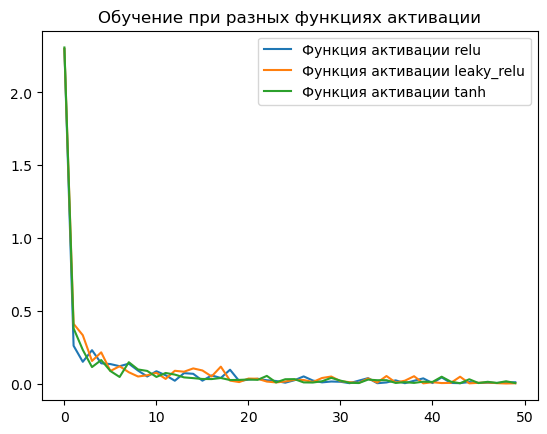


Best accuracy: 98.38%
Best parameters:
hidden_size: 1024
epochs: 10
activation: tanh
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [105]:
# Исследуем функцию активации 'activation': ['relu', 'leaky_relu', 'tanh']

print("Исследование функции активации")
for fn_activ in params_grid['activation']:
    print(f'activation = {fn_activ}')
    params = best_params.copy()
    params['activation'] = fn_activ
    
    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = optim.Adam(model.parameters(), lr=params['optimizer'][1]['lr'], 
                          weight_decay=params['weight_decay'])
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}\n')
    
    results['activation'].append((fn_activ, accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
    
    plt.plot(train_loss, label=f'Функция активации {fn_activ}')
plt.legend()
plt.title('Обучение при разных функциях активации')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")


Исследование регуляризации weight decay (L2)
weight_decay = 0
Epoch 1, Loss: 0.2760
Epoch 2, Loss: 0.1021
Epoch 3, Loss: 0.0659
Epoch 4, Loss: 0.0457
Epoch 5, Loss: 0.0325
Epoch 6, Loss: 0.0231
Epoch 7, Loss: 0.0176
Epoch 8, Loss: 0.0122
Epoch 9, Loss: 0.0112
Epoch 10, Loss: 0.0093
Accuracy on test = 98.13

weight_decay = 0.0001
Epoch 1, Loss: 0.2773
Epoch 2, Loss: 0.1077
Epoch 3, Loss: 0.0735
Epoch 4, Loss: 0.0576
Epoch 5, Loss: 0.0458
Epoch 6, Loss: 0.0388
Epoch 7, Loss: 0.0356
Epoch 8, Loss: 0.0300
Epoch 9, Loss: 0.0279
Epoch 10, Loss: 0.0254
Accuracy on test = 98.26

weight_decay = 0.001
Epoch 1, Loss: 0.2936
Epoch 2, Loss: 0.1416
Epoch 3, Loss: 0.1165
Epoch 4, Loss: 0.1053
Epoch 5, Loss: 0.1000
Epoch 6, Loss: 0.0945
Epoch 7, Loss: 0.0916
Epoch 8, Loss: 0.0891
Epoch 9, Loss: 0.0870
Epoch 10, Loss: 0.0864
Accuracy on test = 97.6



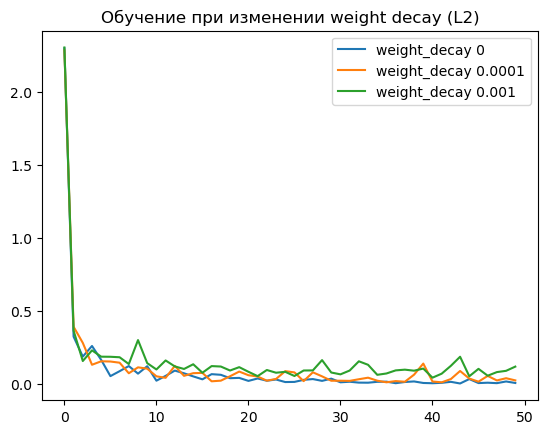


Best accuracy: 98.38%
Best parameters:
hidden_size: 1024
epochs: 10
activation: tanh
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [106]:
# Исследуем регуляризацию – weight decay (L2) ([0, 1e-4, 1e-3])

print("Исследование регуляризации weight decay (L2)")
for wd in params_grid['weight_decay']:
    print(f'weight_decay = {wd}')
    params = best_params.copy()
    params['weight_decay'] = wd
    
    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = optim.Adam(model.parameters(), lr=params['optimizer'][1]['lr'], 
                          weight_decay=params['weight_decay'])
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}\n')
    
    results['weight_decay'].append((wd, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
    
    plt.plot(train_loss, label=f'weight_decay {wd}')
plt.legend()
plt.title('Обучение при изменении weight decay (L2)')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Исследование dropout
dropout = 0
Epoch 1, Loss: 0.2686
Epoch 2, Loss: 0.1023
Epoch 3, Loss: 0.0656
Epoch 4, Loss: 0.0463
Epoch 5, Loss: 0.0336
Epoch 6, Loss: 0.0243
Epoch 7, Loss: 0.0165
Epoch 8, Loss: 0.0132
Epoch 9, Loss: 0.0103
Epoch 10, Loss: 0.0092
Accuracy on test = 98.07

dropout = 0.2
Epoch 1, Loss: 0.2714
Epoch 2, Loss: 0.1027
Epoch 3, Loss: 0.0645
Epoch 4, Loss: 0.0444
Epoch 5, Loss: 0.0315
Epoch 6, Loss: 0.0230
Epoch 7, Loss: 0.0160
Epoch 8, Loss: 0.0135
Epoch 9, Loss: 0.0102
Epoch 10, Loss: 0.0082
Accuracy on test = 98.2

dropout = 0.5
Epoch 1, Loss: 0.2689
Epoch 2, Loss: 0.1014
Epoch 3, Loss: 0.0652
Epoch 4, Loss: 0.0449
Epoch 5, Loss: 0.0322
Epoch 6, Loss: 0.0229
Epoch 7, Loss: 0.0178
Epoch 8, Loss: 0.0128
Epoch 9, Loss: 0.0095
Epoch 10, Loss: 0.0092
Accuracy on test = 97.97



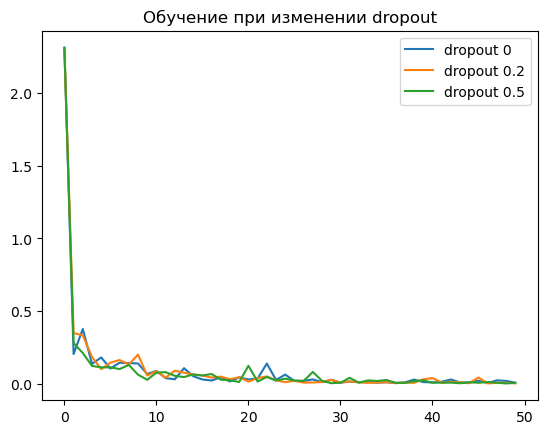


Best accuracy: 98.38%
Best parameters:
hidden_size: 1024
epochs: 10
activation: tanh
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [107]:
# Исследуем dropout ([0, 0.2, 0.5])

print("Исследование dropout")
for drop in params_grid['dropout']:
    print(f'dropout = {drop}')
    params = best_params.copy()
    params['dropout'] = drop
    
    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = optim.Adam(model.parameters(), lr=params['optimizer'][1]['lr'], 
                          weight_decay=params['weight_decay'])
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}\n')
    
    results['dropout'].append((drop, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
    
    plt.plot(train_loss, label=f'dropout {drop}')
plt.legend()
plt.title('Обучение при изменении dropout')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Исследование инициализации весов
init_method = xavier
Epoch 1, Loss: 0.2744
Epoch 2, Loss: 0.1030
Epoch 3, Loss: 0.0646
Epoch 4, Loss: 0.0439
Epoch 5, Loss: 0.0327
Epoch 6, Loss: 0.0237
Epoch 7, Loss: 0.0166
Epoch 8, Loss: 0.0141
Epoch 9, Loss: 0.0107
Epoch 10, Loss: 0.0097
Accuracy on test = 98.11

init_method = kaiming
Epoch 1, Loss: 0.2753
Epoch 2, Loss: 0.1055
Epoch 3, Loss: 0.0662
Epoch 4, Loss: 0.0458
Epoch 5, Loss: 0.0324
Epoch 6, Loss: 0.0233
Epoch 7, Loss: 0.0168
Epoch 8, Loss: 0.0132
Epoch 9, Loss: 0.0105
Epoch 10, Loss: 0.0088
Accuracy on test = 98.2



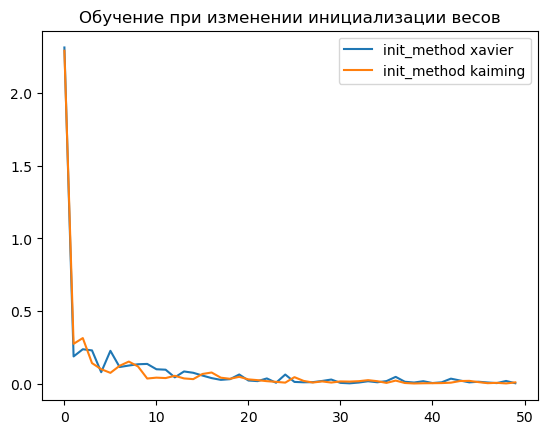


Best accuracy: 98.38%
Best parameters:
hidden_size: 1024
epochs: 10
activation: tanh
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [108]:
# Исследуем инициализацию весов (['xavier', 'kaiming'])

print("Исследование инициализации весов")
for in_m in params_grid['init_method']:
    print(f'init_method = {in_m}')
    params = best_params.copy()
    params['init_method'] = in_m
    
    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = optim.Adam(model.parameters(), lr=params['optimizer'][1]['lr'], 
                          weight_decay=params['weight_decay'])
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}\n')
    
    results['init_method'].append((in_m, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
    
    plt.plot(train_loss, label=f'init_method {in_m}')
plt.legend()
plt.title('Обучение при изменении инициализации весов')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Исследование нормализации по мини-батчам
use_bn = True
Epoch 1, Loss: 0.2716
Epoch 2, Loss: 0.1028
Epoch 3, Loss: 0.0663
Epoch 4, Loss: 0.0450
Epoch 5, Loss: 0.0328
Epoch 6, Loss: 0.0229
Epoch 7, Loss: 0.0173
Epoch 8, Loss: 0.0153
Epoch 9, Loss: 0.0093
Epoch 10, Loss: 0.0074
Accuracy on test = 97.84

use_bn = False
Epoch 1, Loss: 0.2699
Epoch 2, Loss: 0.0989
Epoch 3, Loss: 0.0647
Epoch 4, Loss: 0.0451
Epoch 5, Loss: 0.0313
Epoch 6, Loss: 0.0226
Epoch 7, Loss: 0.0176
Epoch 8, Loss: 0.0137
Epoch 9, Loss: 0.0109
Epoch 10, Loss: 0.0081
Accuracy on test = 98.28



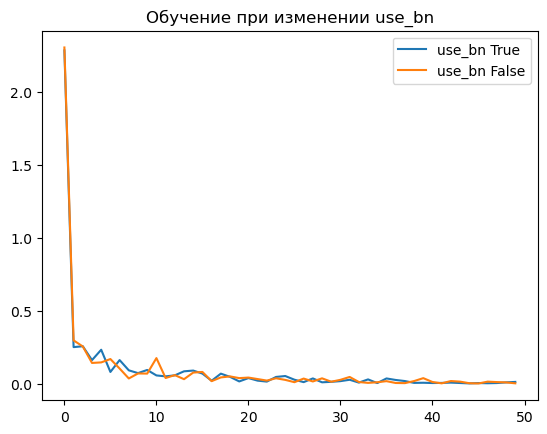


Best accuracy: 98.38%
Best parameters:
hidden_size: 1024
epochs: 10
activation: tanh
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [109]:
# Исследуем нормализацию по мини-батчам (есть, нет) ([True, False])                      

print("Исследование нормализации по мини-батчам")
for mb in params_grid['use_bn']:
    print(f'use_bn = {mb}')
    params = best_params.copy()
    params['use_bn'] = mb
    
    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = optim.Adam(model.parameters(), lr=params['optimizer'][1]['lr'], 
                          weight_decay=params['weight_decay'])
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}\n')
    
    results['use_bn'].append((mb, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
    
    plt.plot(train_loss, label=f'use_bn {mb}')
plt.legend()
plt.title('Обучение при изменении use_bn')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Исследование оптимизаторов
optimizer = ('SGD', {'lr': 0.1})
Epoch 1, Loss: 0.5368
Epoch 2, Loss: 0.2748
Epoch 3, Loss: 0.2208
Epoch 4, Loss: 0.1844
Epoch 5, Loss: 0.1579
Epoch 6, Loss: 0.1373
Epoch 7, Loss: 0.1215
Epoch 8, Loss: 0.1086
Epoch 9, Loss: 0.0979
Epoch 10, Loss: 0.0891
Accuracy on test = 97.16

optimizer = ('Momentum', {'lr': 0.01, 'momentum': 0.9})
Epoch 1, Loss: 0.5684
Epoch 2, Loss: 0.2767
Epoch 3, Loss: 0.2238
Epoch 4, Loss: 0.1872
Epoch 5, Loss: 0.1597
Epoch 6, Loss: 0.1398
Epoch 7, Loss: 0.1231
Epoch 8, Loss: 0.1102
Epoch 9, Loss: 0.0997
Epoch 10, Loss: 0.0907
Accuracy on test = 97.18

optimizer = ('Nesterov', {'lr': 0.01, 'momentum': 0.9, 'nesterov': True})
Epoch 1, Loss: 0.5648
Epoch 2, Loss: 0.2761
Epoch 3, Loss: 0.2216
Epoch 4, Loss: 0.1854
Epoch 5, Loss: 0.1585
Epoch 6, Loss: 0.1384
Epoch 7, Loss: 0.1225
Epoch 8, Loss: 0.1094
Epoch 9, Loss: 0.0991
Epoch 10, Loss: 0.0902
Accuracy on test = 97.08

optimizer = ('Adam', {'lr': 0.001})
Epoch 1, Loss: 0.2760
Epoch 2, Lo

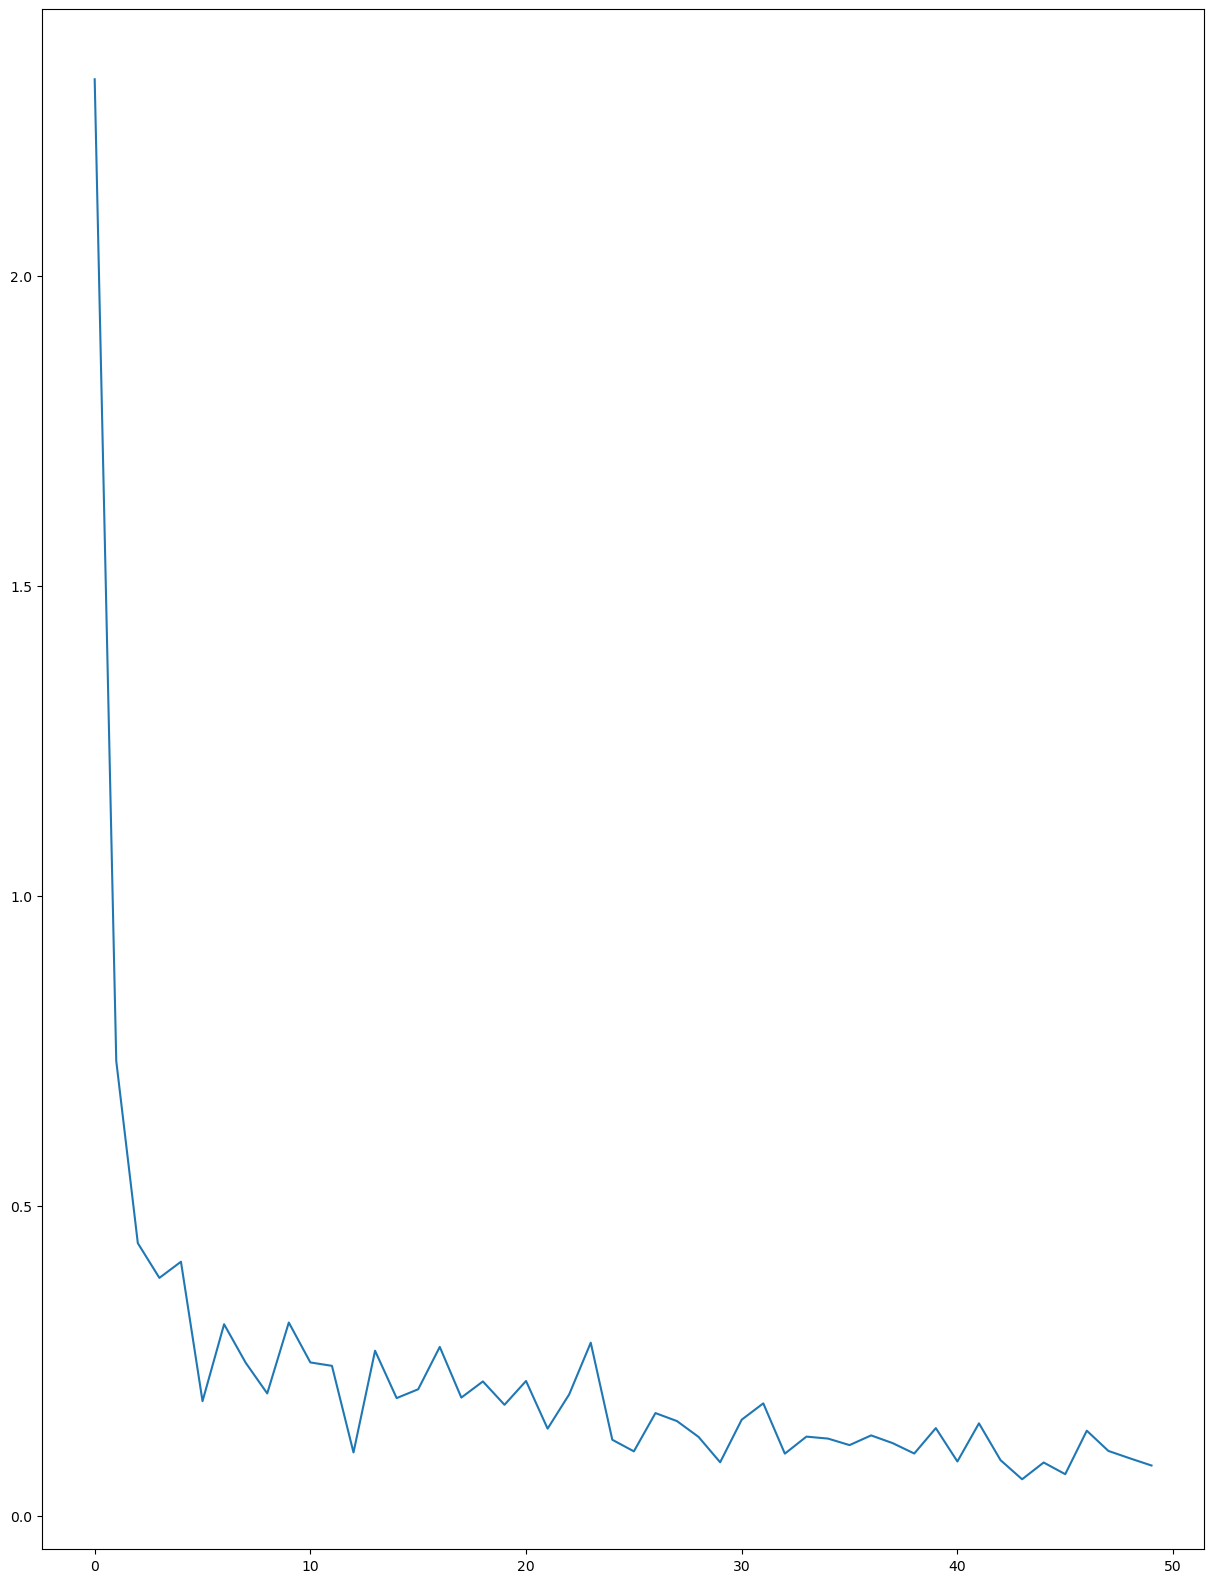

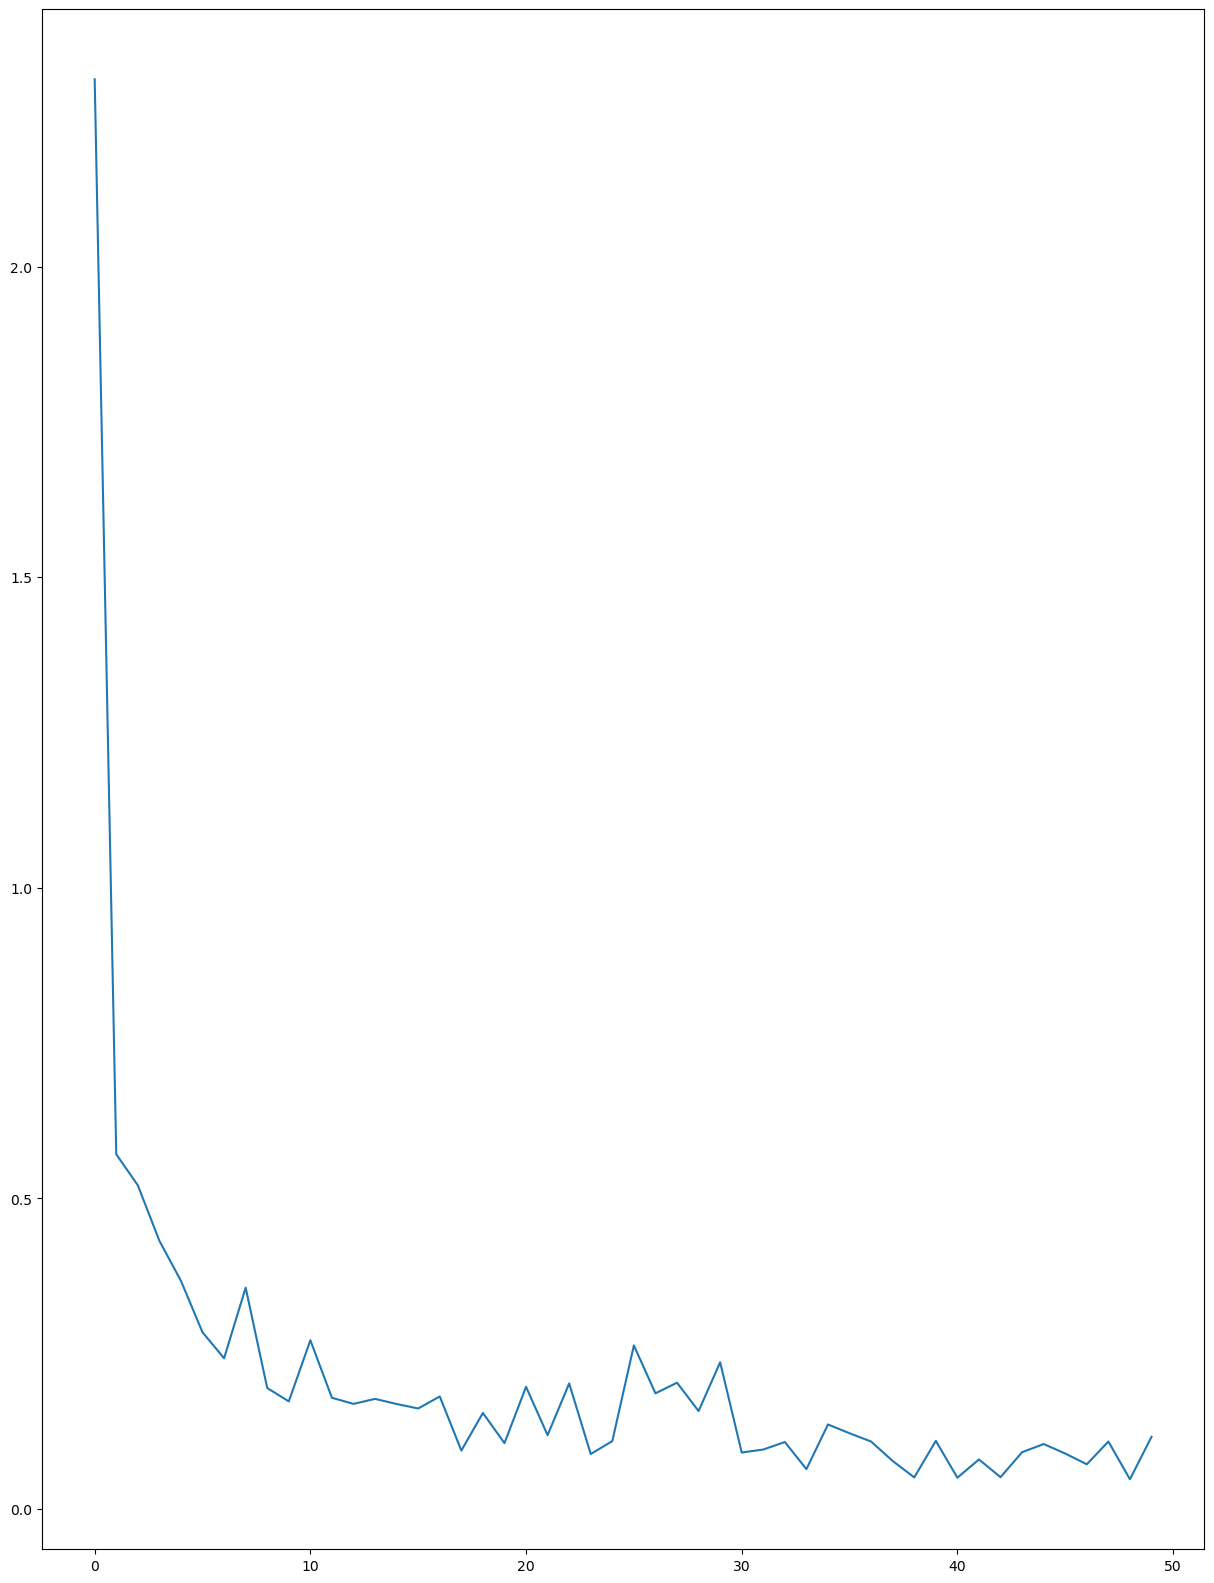

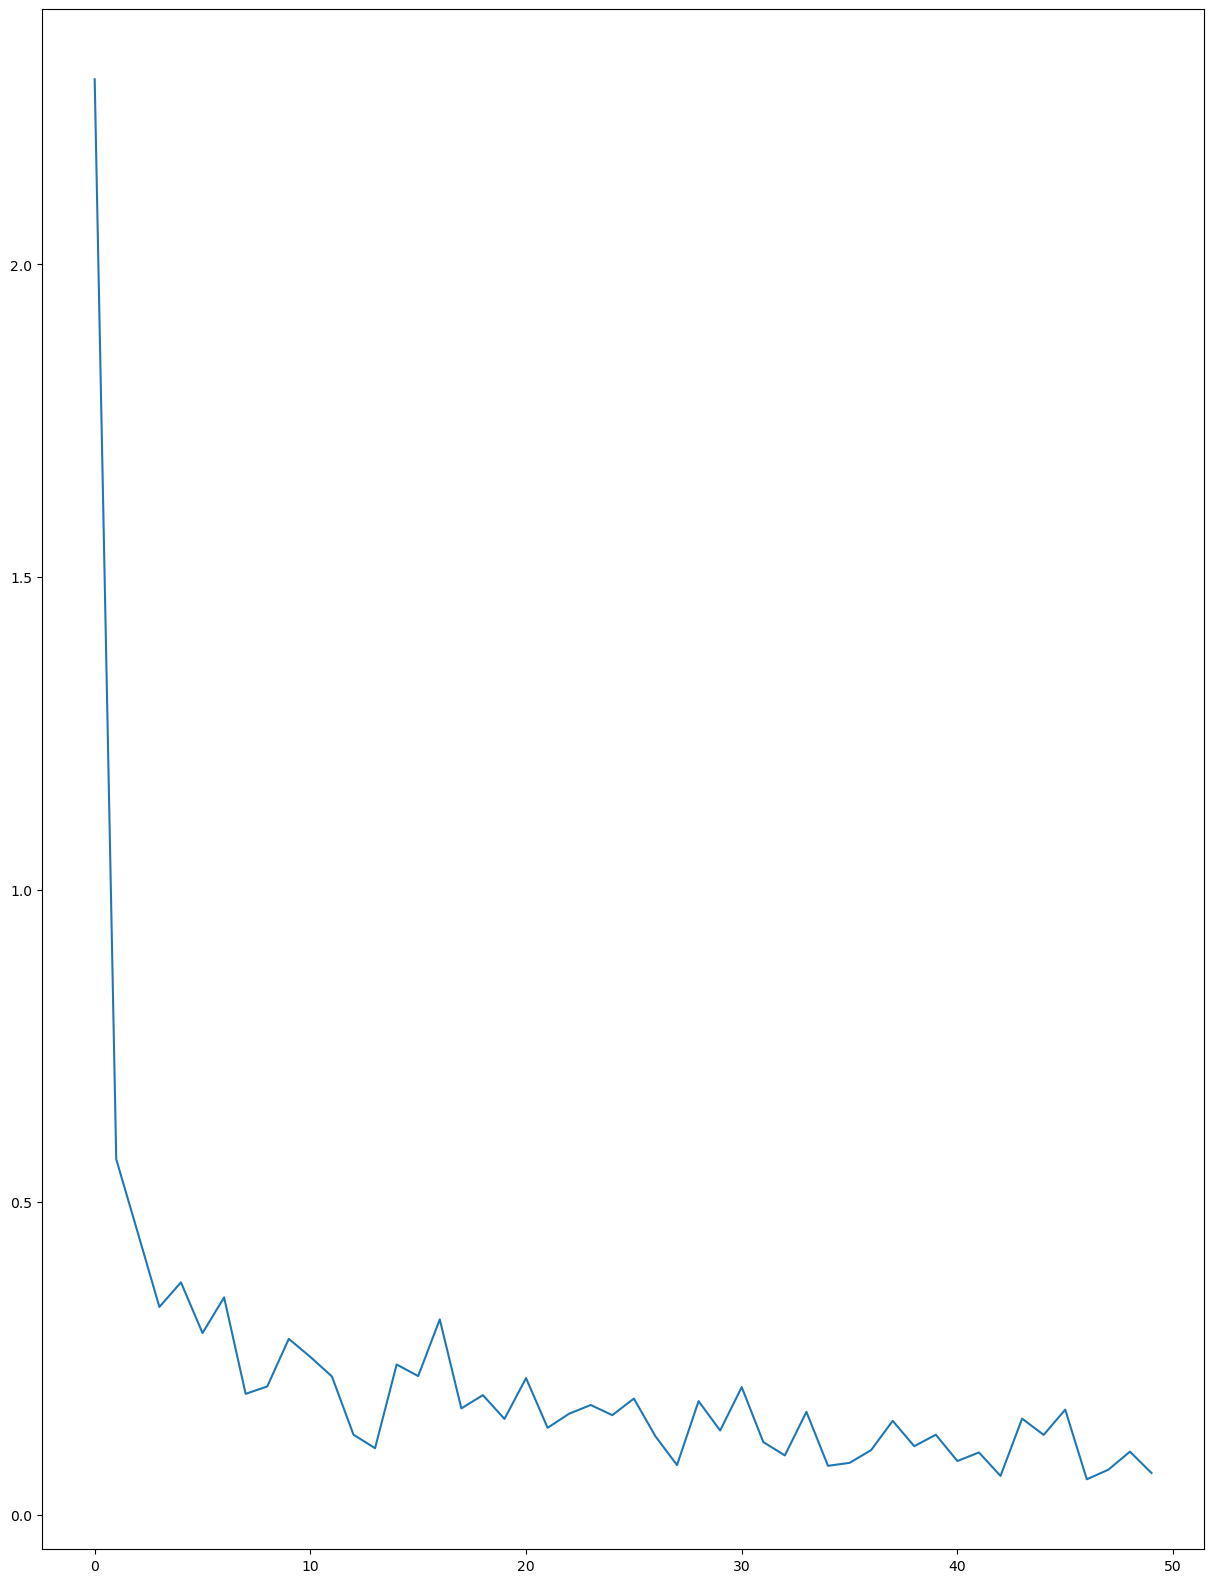

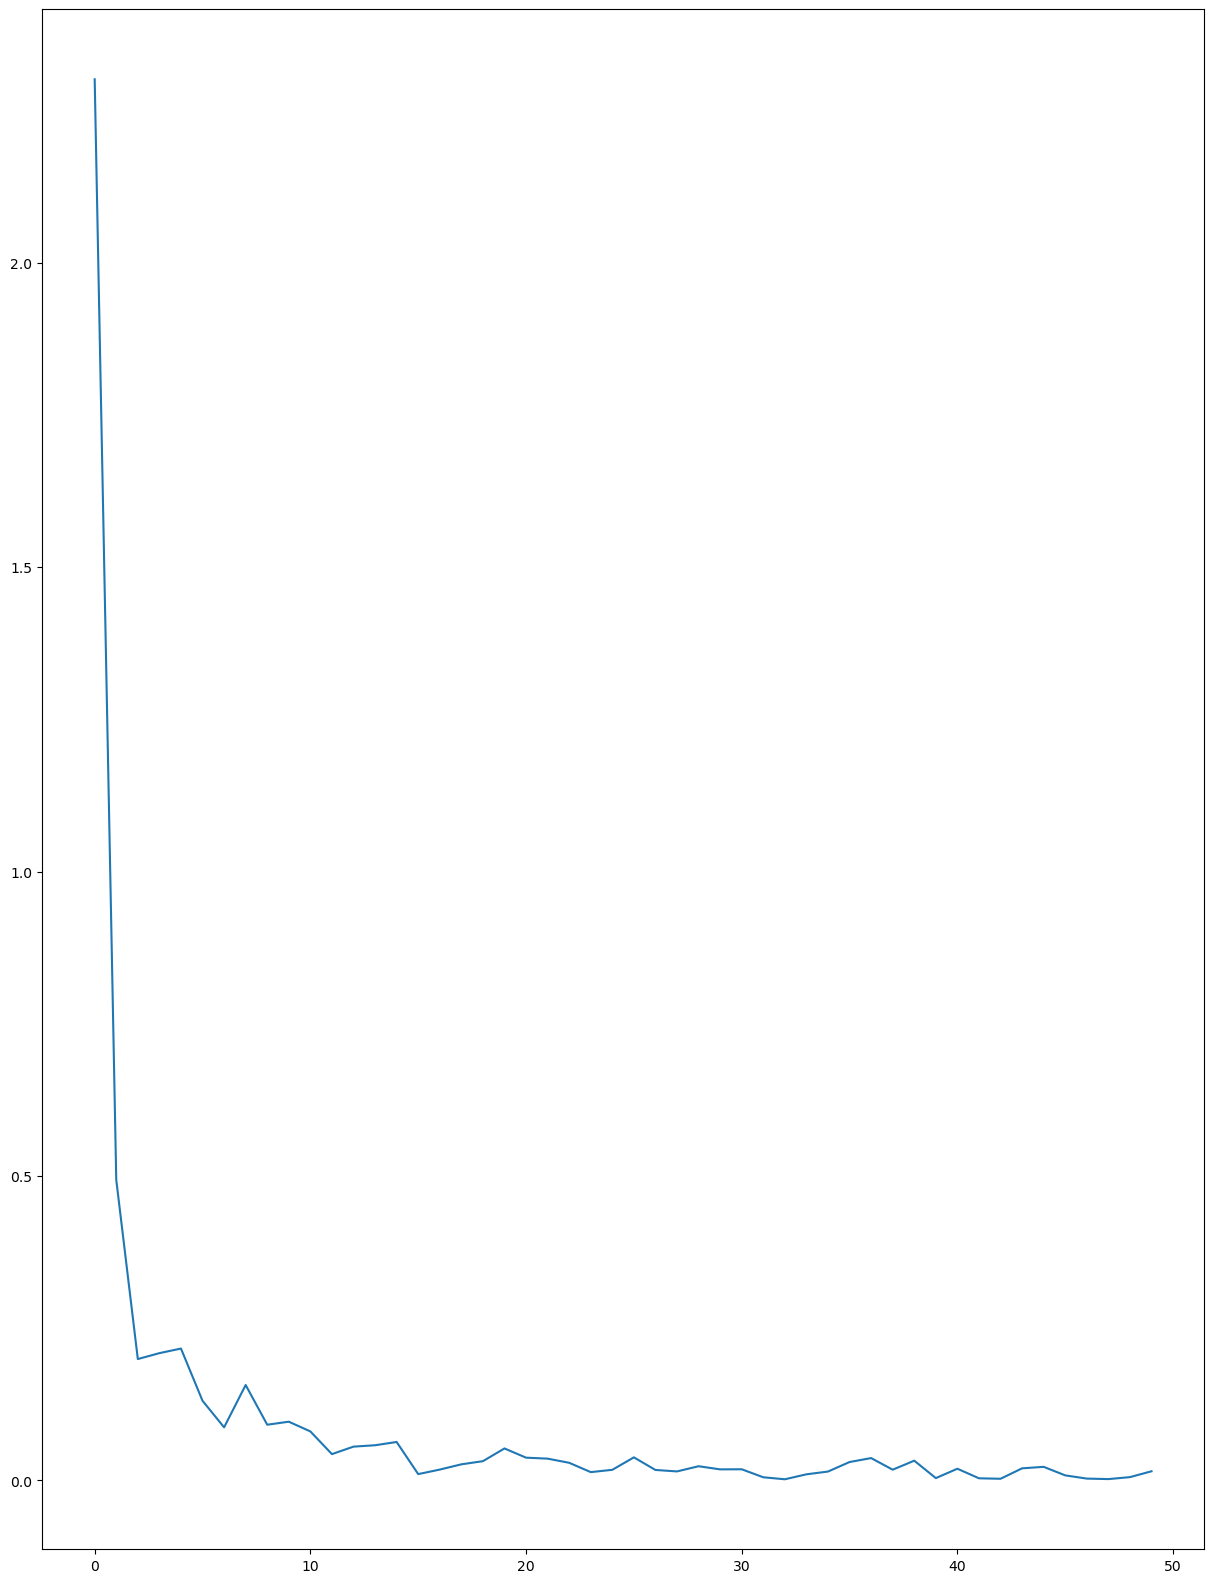

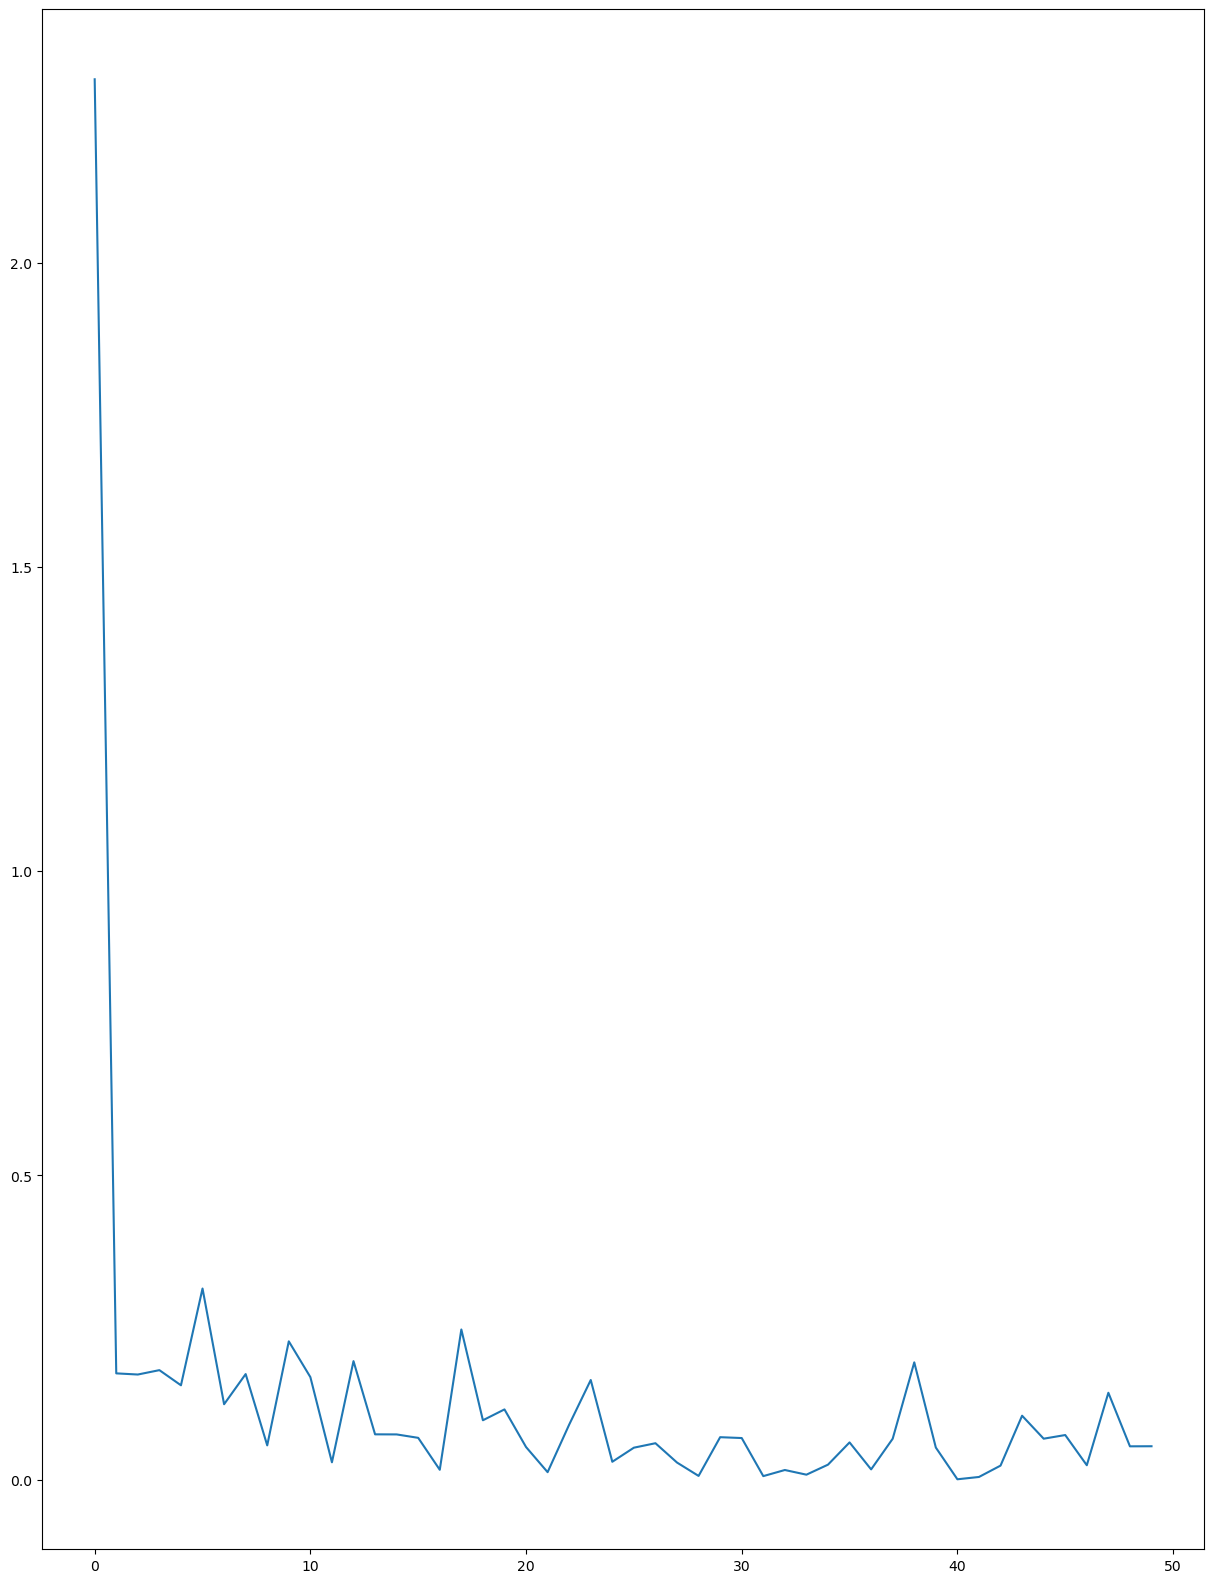

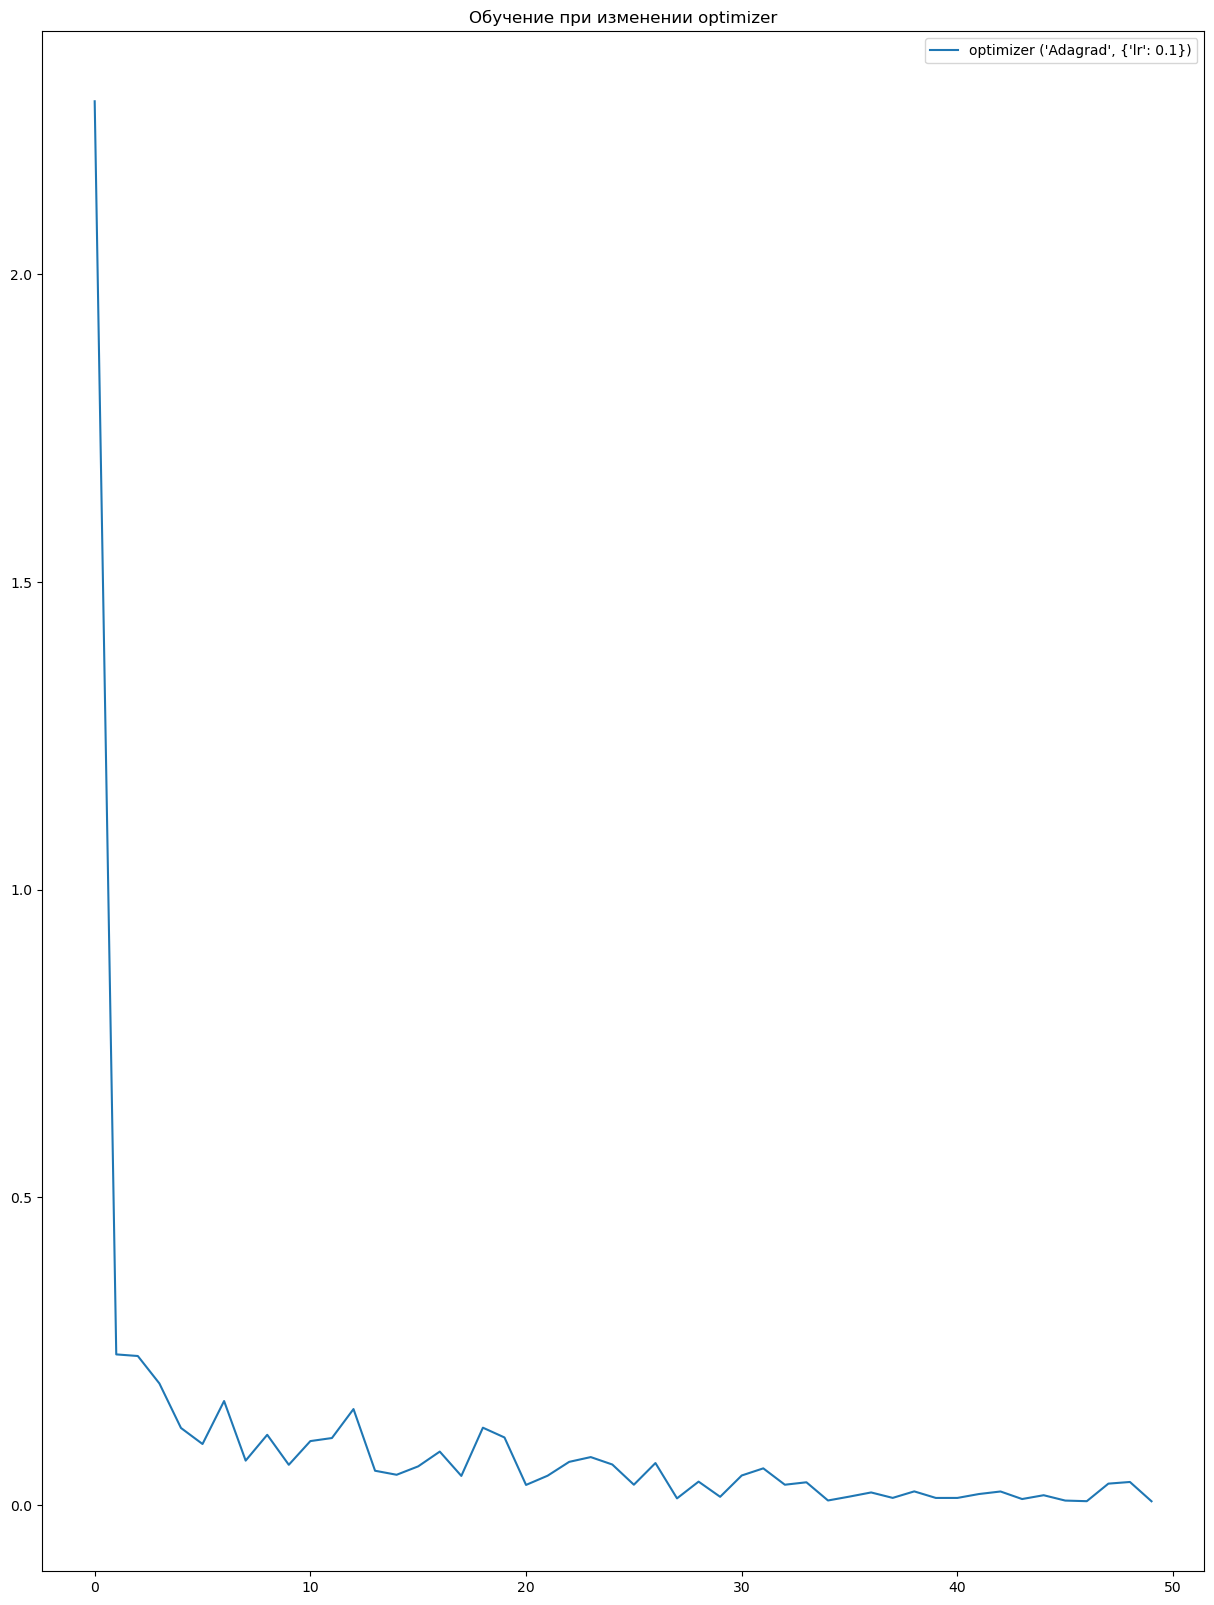


Best accuracy: 98.38%
Best parameters:
hidden_size: 1024
epochs: 10
activation: tanh
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


In [110]:
# Исследование по оптимизатору ( 'optimizer': [
#        ('SGD', {'lr': 0.1}),
#        ('Momentum', {'lr': 0.01, 'momentum': 0.9}),
#        ('Nesterov', {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}),
#        ('Adam', {'lr': 0.001}),
#        ('RMSprop', {'lr': 0.01}),
#        ('Adagrad', {'lr': 0.1})
#    ] )

#  для создания оптимизатора
def get_optimizer(model, config):
    name, params = config
    if name == 'SGD':
        return optim.SGD(model.parameters(), **params)
    elif name == 'Momentum':
        return optim.SGD(model.parameters(), **params)
    elif name == 'Nesterov':
        return optim.SGD(model.parameters(), **params)
    elif name == 'Adam':
        return optim.Adam(model.parameters(), **params)
    elif name == 'RMSprop':
        return optim.RMSprop(model.parameters(), **params)
    elif name == 'Adagrad':
        return optim.Adagrad(model.parameters(), **params)
    else:
        raise ValueError(f"Unknown optimizer: {name}")
        
print("Исследование оптимизаторов")
for config in params_grid['optimizer']:
    print(f'optimizer = {config}')
    params = best_params.copy()
    params['optimizer'] = config

    model = CustomizableNN(hidden_size=params['hidden_size']).to(Config.device)
    init_weights(model, params['init_method'])
    
    optimizer = get_optimizer(model, config)
    
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.test_batch_size)
    
    train_loss = train(model, optimizer, train_loader, params['epochs'])
    accuracy = test(model, test_loader)
    print(f'Accuracy on test = {accuracy}\n')
    
    results['optimizer'].append((config, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params.copy()
        
    #plt.figure(figsize=(15, 20))
    plt.plot(train_loss, label=f'optimizer {config}')
plt.legend()
plt.title('Обучение при изменении optimizer')
plt.show()

# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")


Best accuracy: 98.38%
Best parameters:
hidden_size: 1024
epochs: 10
activation: tanh
weight_decay: 0
dropout: 0
init_method: xavier
use_bn: False
optimizer: ('Adam', {'lr': 0.001})


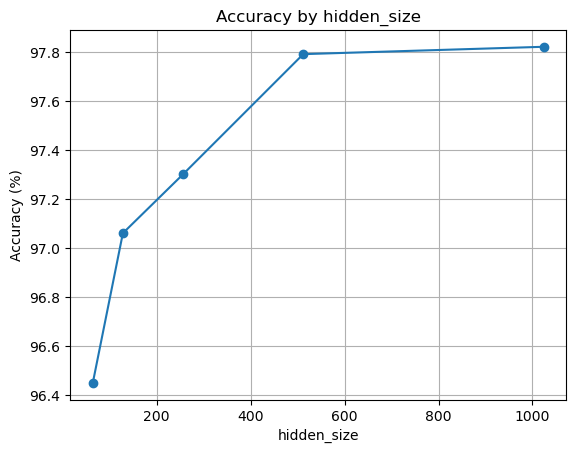

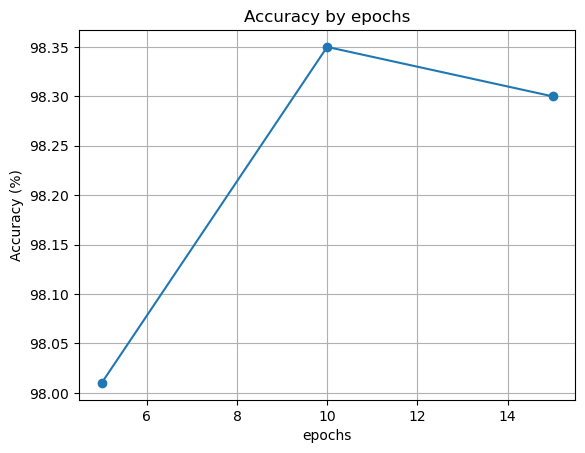

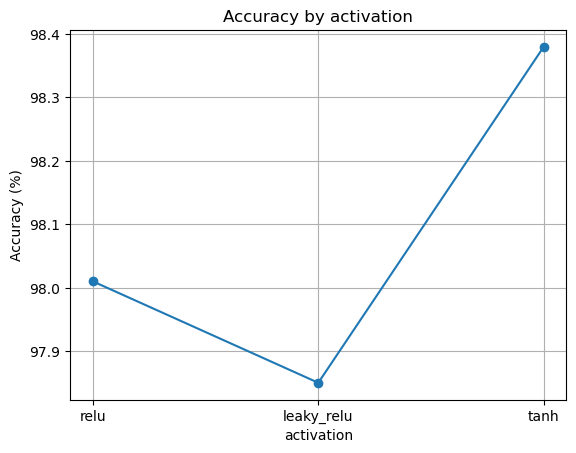

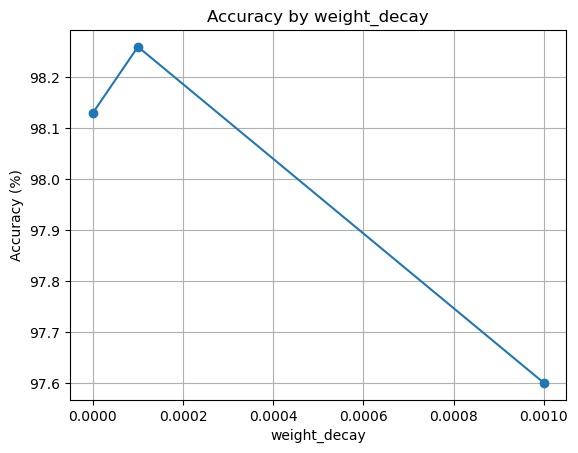

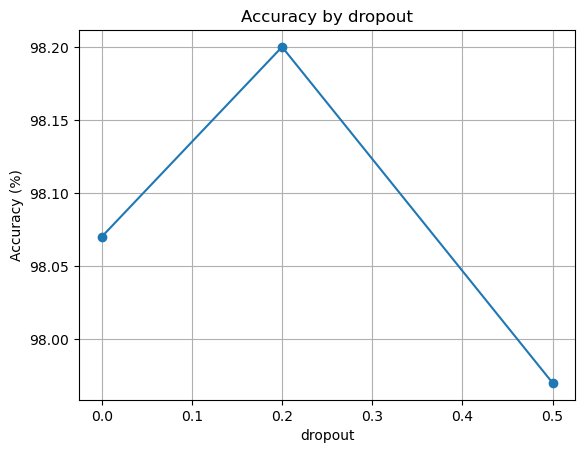

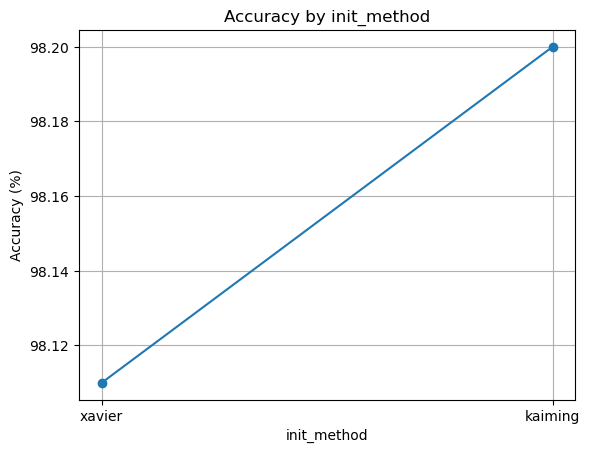

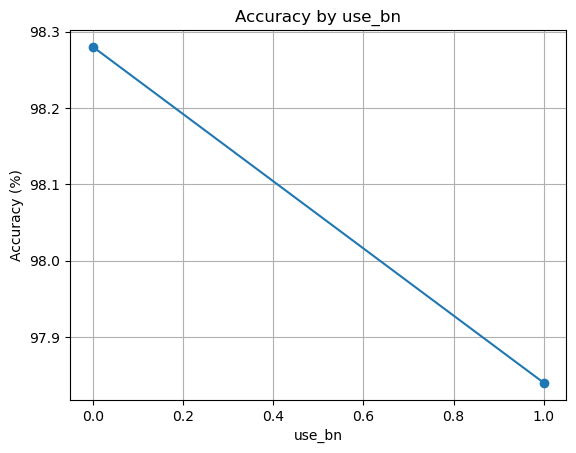

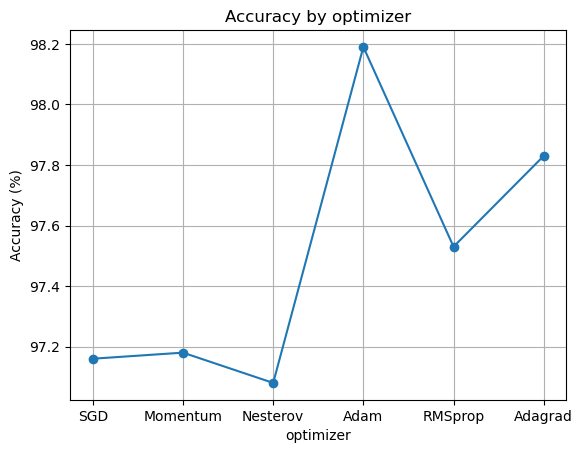

In [111]:
# Финальные показатели лучшей модели
# Вывод результатов
print("\nBest accuracy: {:.2f}%".format(best_accuracy))
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

# Визуализация результатов (изменение accuracy на тестовых данных при разных значениях гиперпараметров (для каждого гиперпараметра в отдельности))
for param, values in results.items():
    plt.figure()
    if param == 'optimizer':
        x = [v[0][0] for v in values]
    else:
        x = [v[0] for v in values]
    y = [v[1] for v in values]
    plt.plot(x, y, 'o-')
    plt.title(f'Accuracy by {param}')
    plt.xlabel(param)
    plt.ylabel('Accuracy (%)')
    plt.grid()
plt.show()

#### Задания (факультативные).
1. Прочитать параграф 3.6 в учебнике С. Николенко и др. (стр. 123–135) и воспроизвести рассмотренные там нейронные сети на TensorFlow.
1. Воспроизвести пример на Keras на стр. 147–149.
1. Воспроизвести пример на TensorFlow на стр. 158–159.